# Apply Random Forests & GBDT on Amazon Fine Food Reviews.


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


### Objective:
#### Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\HIMANSHU NEGI\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:01<00:00, 1429.16it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [5] Random Forests

## [5.1] Applying RF

In [24]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc


from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display


In [33]:
# Please write all the code with proper documentation
#spilliting data 
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)


### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [34]:
# Please write all the code with proper documentation
#code for VECTORIZER
count_vect = CountVectorizer(min_df = 10) 
Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (43008, 8135)
the number of unique words : 8135


In [35]:
# Data-preprocessing: Standardizing the data
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.transform(Xbow_cv)

In [38]:
#code for hyperparameter tuning
import numpy as np
hyper1 =  [5, 10, 50, 100, 200, 500, 1000]
hyper2 =  [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc1=np.empty((7,9))
auc2=np.empty((7,9))
l=0
for j in hyper1:
    m=0
    for k in hyper2:
        
        model = RandomForestClassifier(n_estimators=j,max_depth=k)
        model.fit(Xbow_tr_std, y_tr)
    
        probs = model.predict_proba(Xbow_tr_std)
        preds = probs[:,1]
        roc_auc1=metrics.roc_auc_score(y_tr, preds)
        auc1[l][m]=(roc_auc1)
    
  
        probs = model.predict_proba(Xbow_cv_std)
        preds = probs[:,1]
        roc_auc2=metrics.roc_auc_score(y_cv, preds)
        auc2[l][m]=(roc_auc2)
        m=m+1
        
    l=l+1
    
    



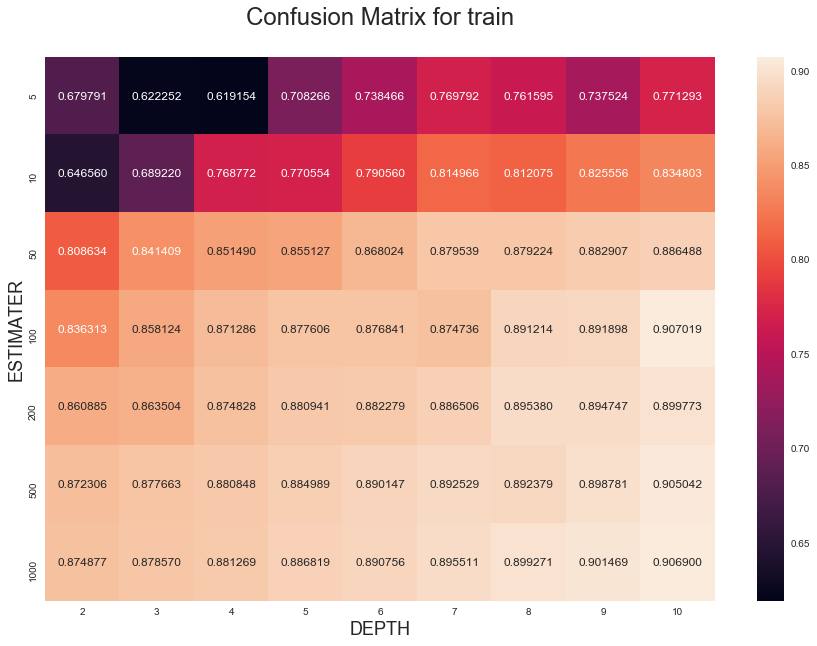

In [42]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc1, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")

plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for train\n",size=24)
plt.show()

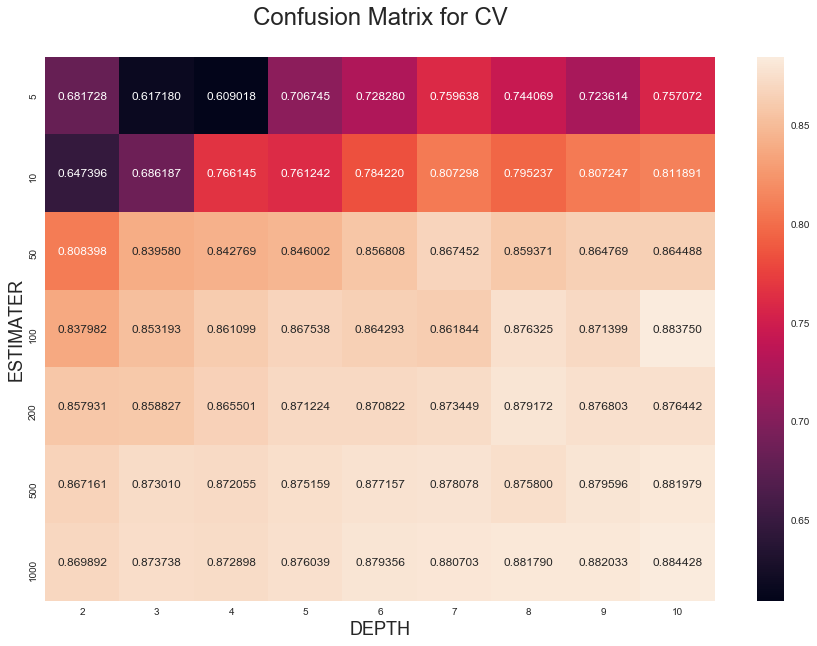

In [41]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc2, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")

plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for CV\n",size=24)
plt.show()

In [44]:
rf = RandomForestClassifier(n_estimators=50,max_depth=3)

# fitting the model
rf.fit(Xbow_tr_std, y_tr)

# predict the response
pred = rf.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the Random forest classifier for n_estimaters=%f and Depth = %f is %f%%' % (50,3, acc))


The accuracy of the Random forest classifier for n_estimaters=50.000000 and Depth = 3.000000 is 83.943491%


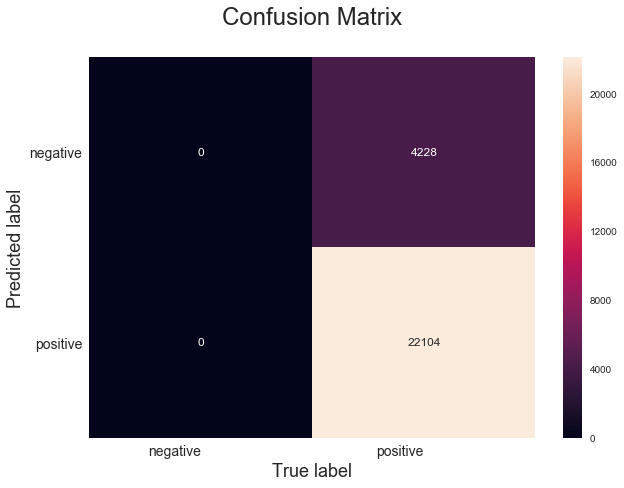

In [48]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [49]:
rf.fit(Xbow_tr_std, y_tr)
probs2 = rf.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = rf.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

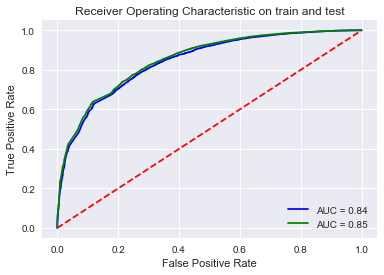

In [50]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

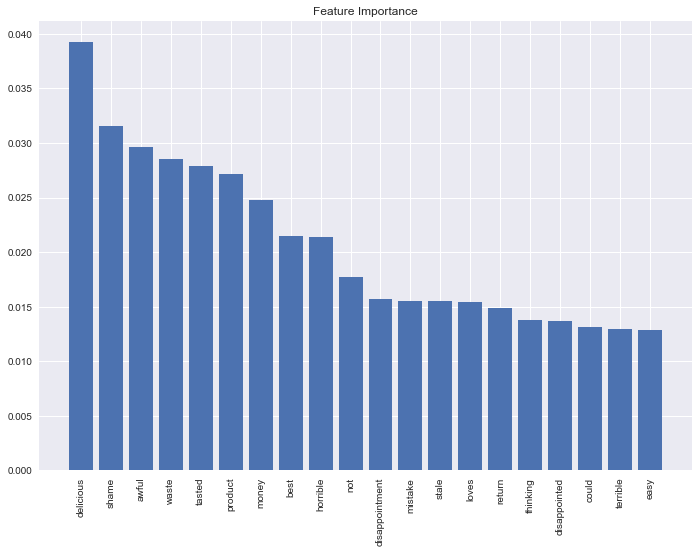

In [51]:
#refer code snippet for top 20 feature extraction
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
# Calculate feature importances from decision trees
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(20), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()from sklearn import tree



In [52]:
z=names[indices]

In [53]:
z

array(['delicious', 'shame', 'awful', 'waste', 'tasted', 'product',
       'money', 'best', 'horrible', 'not', 'disappointment', 'mistake',
       'stale', 'loves', 'return', 'thinking', 'disappointed', 'could',
       'terrible', 'easy'], dtype='<U16')

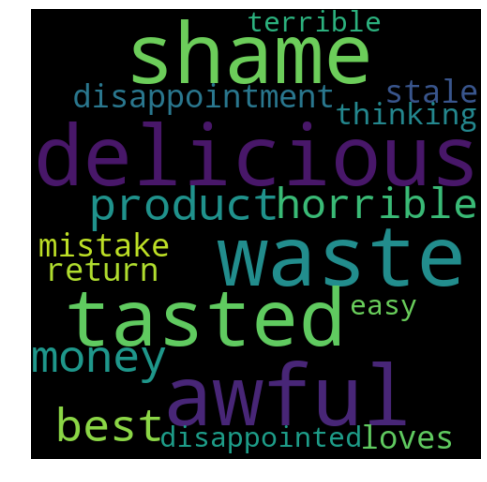

In [100]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
# Create a list of word
text=("delicious shame awful waste tasted product money best horrible not disappointment mistake stale loves return thinking disappointed could terrible easy") 
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [71]:
# Please write all the code with proper documentation
#code for VECTORIZER
count_vect  = TfidfVectorizer(ngram_range=(1,2), min_df=10)

Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (43008, 25776)
the number of unique words : 25776


In [72]:
# Data-preprocessing: Standardizing the data
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.transform(Xbow_cv)

In [73]:
#code for hyperparameter tuning
import numpy as np
hyper1 =  [5, 10, 50, 100, 200, 500, 1000]
hyper2 =  [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc1=np.empty((7,9))
auc2=np.empty((7,9))
l=0
for j in hyper1:
    m=0
    for k in hyper2:
        
        model = RandomForestClassifier(n_estimators=j,max_depth=k)
        model.fit(Xbow_tr_std, y_tr)
    
        probs = model.predict_proba(Xbow_tr_std)
        preds = probs[:,1]
        roc_auc1=metrics.roc_auc_score(y_tr, preds)
        auc1[l][m]=(roc_auc1)
    
  
        probs = model.predict_proba(Xbow_cv_std)
        preds = probs[:,1]
        roc_auc2=metrics.roc_auc_score(y_cv, preds)
        auc2[l][m]=(roc_auc2)
        m=m+1
        
    l=l+1
    
    



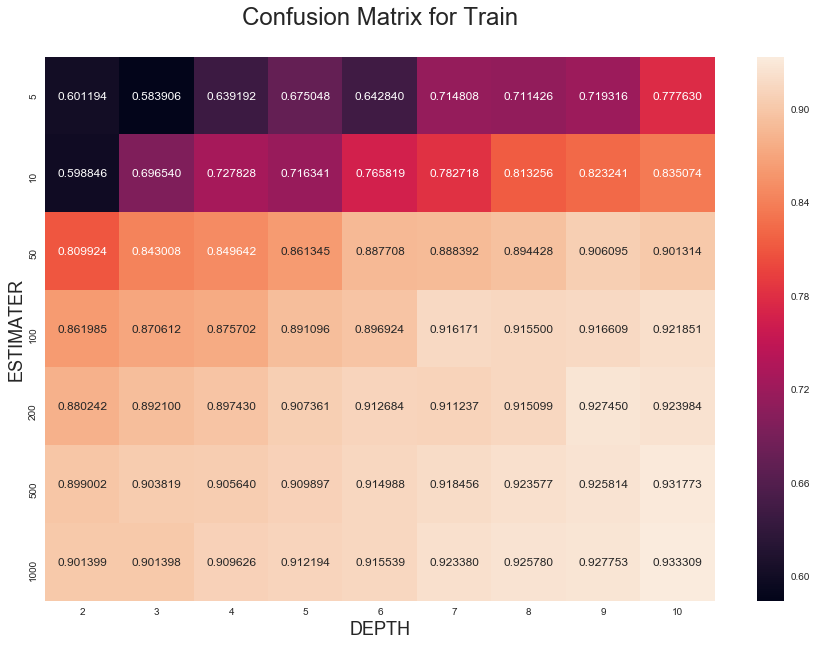

In [74]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc1, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for Train\n",size=24)
plt.show()

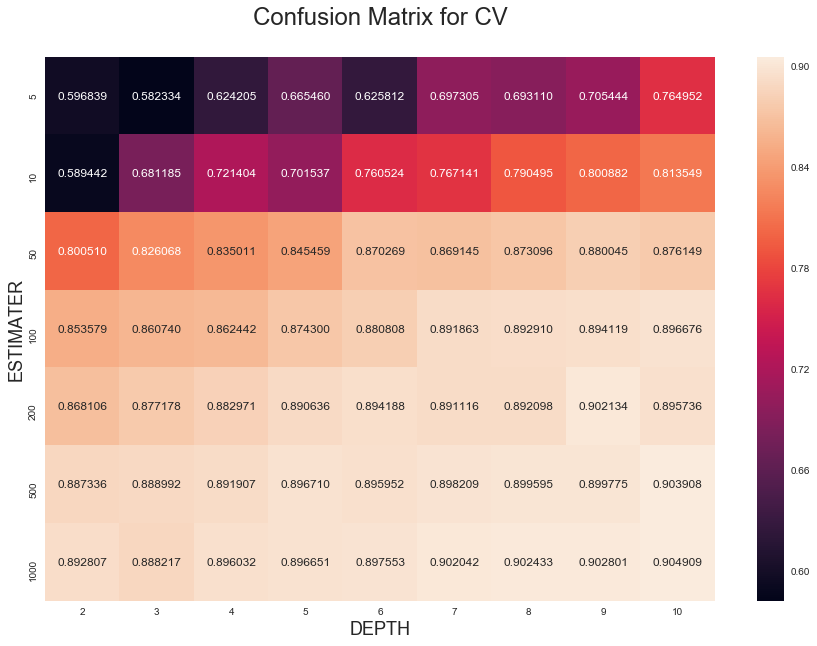

In [75]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc2, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for CV\n",size=24)
plt.show()

In [92]:
rf = RandomForestClassifier(n_estimators=100,max_depth=4)

# fitting the model
rf.fit(Xbow_tr_std, y_tr)

# predict the response
pred = rf.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the Random forest classifier for n_estimaters=%d and Depth = %d is %f%%' % (100,4, acc))


The accuracy of the Random forest classifier for n_estimaters=100 and Depth = 4 is 83.943491%


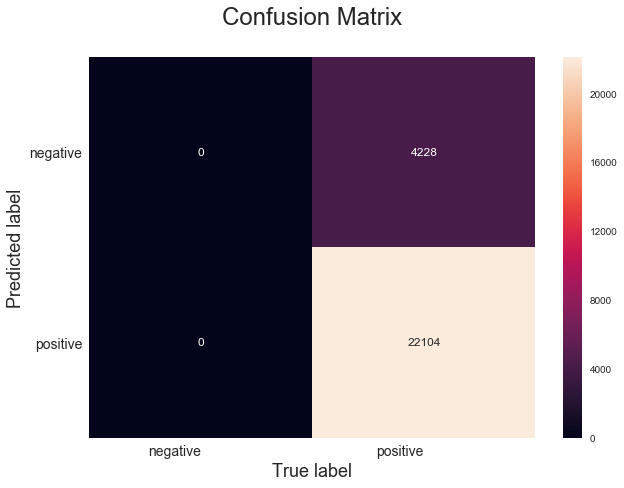

In [93]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [94]:

rf.fit(Xbow_tr_std, y_tr)
probs2 = rf.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = rf.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

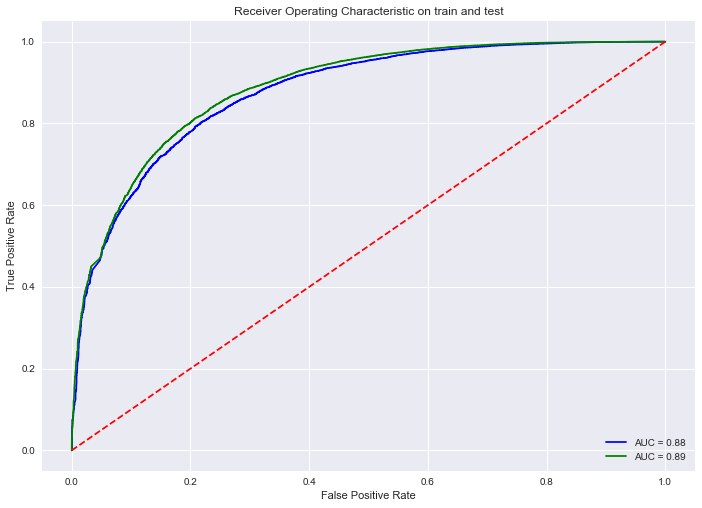

In [95]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

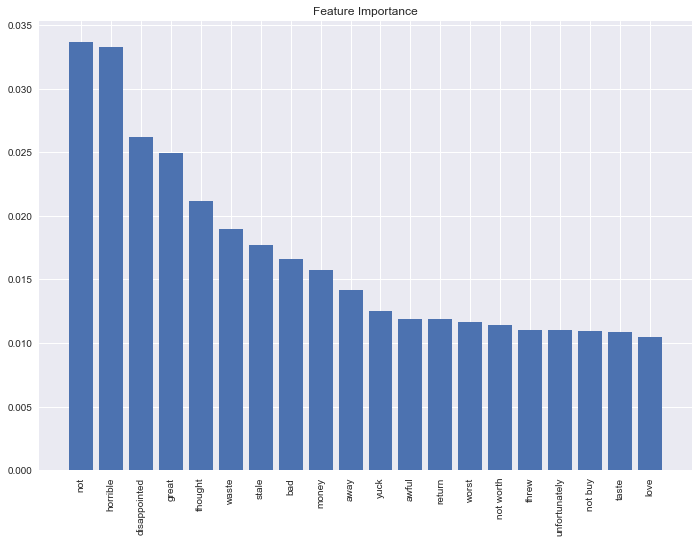

In [96]:
#refer code snippet for top 20 feature extraction
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
# Calculate feature importances from decision trees
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(20), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()from sklearn import tree



In [97]:
z=names[indices]
z

array(['not', 'horrible', 'disappointed', 'great', 'thought', 'waste',
       'stale', 'bad', 'money', 'away', 'yuck', 'awful', 'return',
       'worst', 'not worth', 'threw', 'unfortunately', 'not buy', 'taste',
       'love'], dtype='<U27')

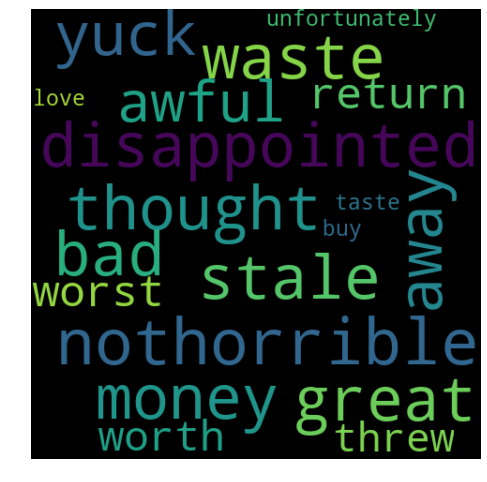

In [99]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
# Create a list of word
text=("nothorrible disappointed great thought waste stale bad money away yuck awful return worst not worth threw unfortunately not buy taste love") 
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [115]:
# Please write all the code with proper documentation
# List of sentence in X_train text
sent_of_train=[]
for sent in X_tr:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
    sent_of_cv=[]
for sent in X_cv:
    sent_of_cv.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  12546


In [117]:
# compute average word2vec for each review for X_train .
Xbow_tr = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_tr.append(sent_vec)
    
# compute average word2vec for each review for X_test .
Xbow_test = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_test.append(sent_vec)
  #gdfghsdgfsdgfhsdgfdhsgfhgdhgfhdghfg


    Xbow_cv = []; 
for sent in sent_of_cv:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_cv.append(sent_vec)

In [118]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.transform(Xbow_cv)

In [119]:
#code for hyperparameter tuning
import numpy as np
hyper1 =  [5, 10, 50, 100, 200, 500, 1000]
hyper2 =  [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc1=np.empty((7,9))
auc2=np.empty((7,9))
l=0
for j in hyper1:
    m=0
    for k in hyper2:
        
        model = RandomForestClassifier(n_estimators=j,max_depth=k)
        model.fit(Xbow_tr_std, y_tr)
    
        probs = model.predict_proba(Xbow_tr_std)
        preds = probs[:,1]
        roc_auc1=metrics.roc_auc_score(y_tr, preds)
        auc1[l][m]=(roc_auc1)
    
  
        probs = model.predict_proba(Xbow_cv_std)
        preds = probs[:,1]
        roc_auc2=metrics.roc_auc_score(y_cv, preds)
        auc2[l][m]=(roc_auc2)
        m=m+1
        
    l=l+1
    
    



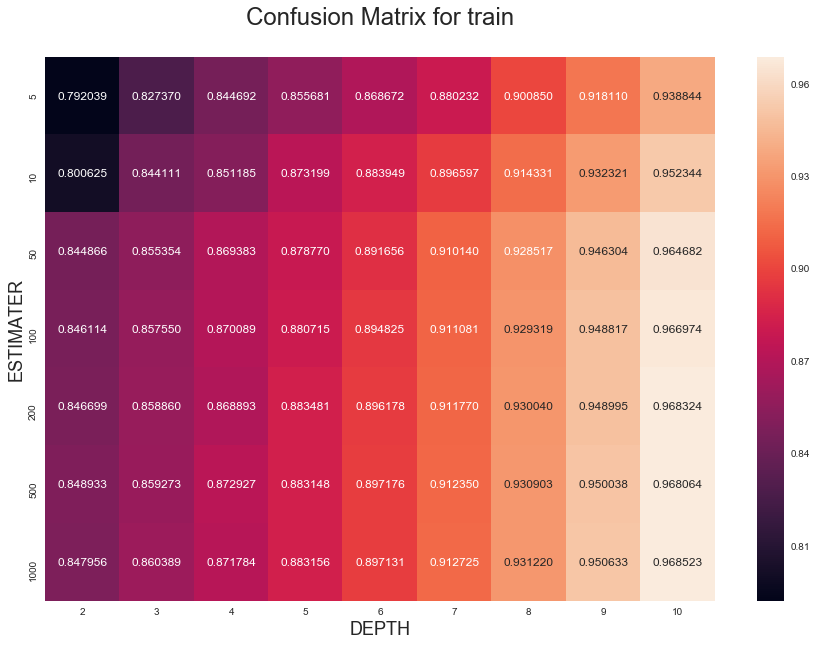

In [120]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc1, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")

plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for train\n",size=24)
plt.show()

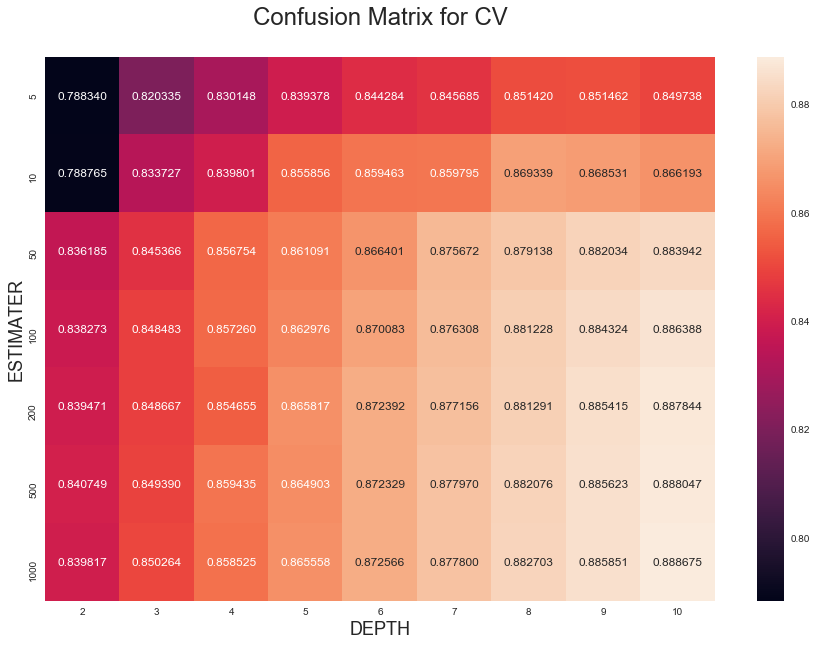

In [121]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc2, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")

plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for CV\n",size=24)
plt.show()

In [125]:
rf = RandomForestClassifier(n_estimators=10,max_depth=4)

# fitting the model
rf.fit(Xbow_tr_std, y_tr)

# predict the response
pred = rf.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the Random forest classifier for n_estimaters=%d and Depth = %d is %f%%' % (10,4, acc))


The accuracy of the Random forest classifier for n_estimaters=10 and Depth = 4 is 84.080207%


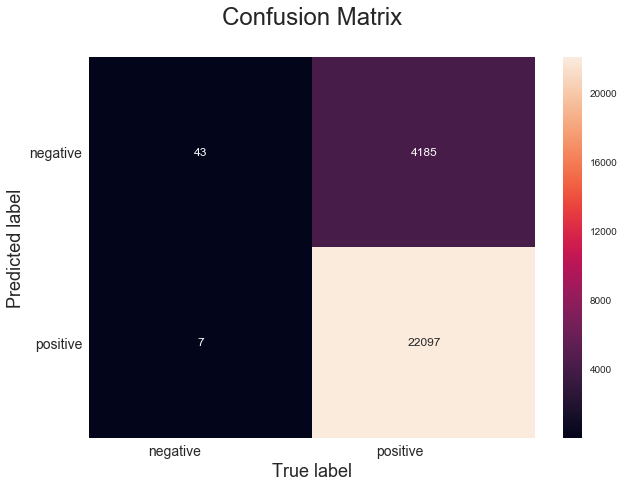

In [127]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [128]:

rf.fit(Xbow_tr_std, y_tr)
probs2 = rf.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = rf.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

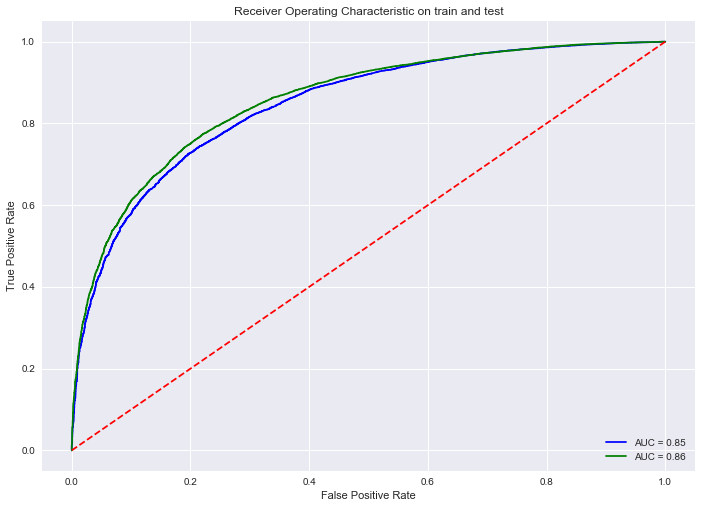

In [129]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [139]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [140]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_tr.append(sent_vec)
    row += 1

In [141]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

model.transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [142]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for​r  if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_cv.append(sent_vec)
    row += 1

In [143]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [144]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_test.append(sent_vec)
    row += 1

In [145]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.transform(Xbow_cv)

In [146]:
#code for hyperparameter tuning
import numpy as np
hyper1 =  [5, 10, 50, 100, 200, 500, 1000]
hyper2 =  [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc1=np.empty((7,9))
auc2=np.empty((7,9))
l=0
for j in hyper1:
    m=0
    for k in hyper2:
        
        model = RandomForestClassifier(n_estimators=j,max_depth=k)
        model.fit(Xbow_tr_std, y_tr)
    
        probs = model.predict_proba(Xbow_tr_std)
        preds = probs[:,1]
        roc_auc1=metrics.roc_auc_score(y_tr, preds)
        auc1[l][m]=(roc_auc1)
    
  
        probs = model.predict_proba(Xbow_cv_std)
        preds = probs[:,1]
        roc_auc2=metrics.roc_auc_score(y_cv, preds)
        auc2[l][m]=(roc_auc2)
        m=m+1
        
    l=l+1
    
    



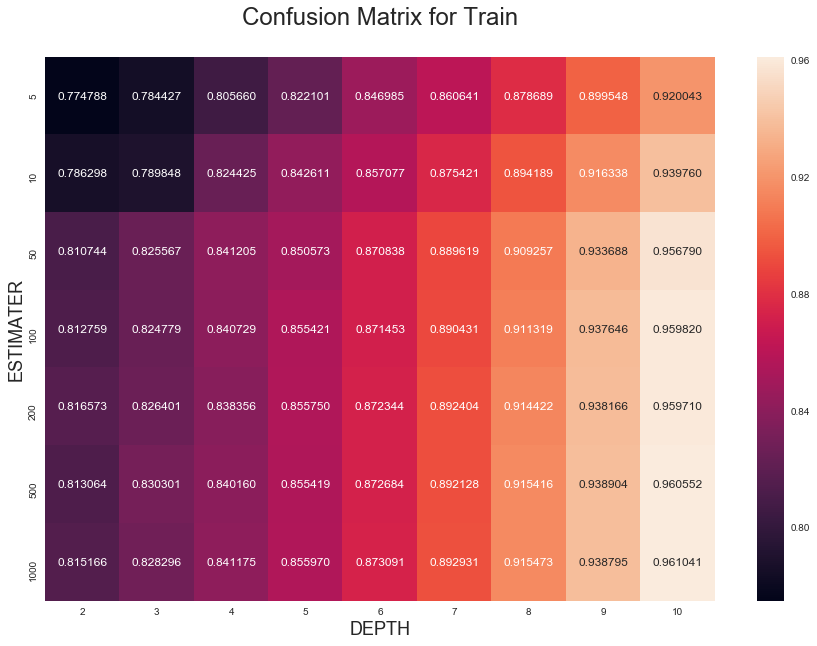

In [147]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc1, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for Train\n",size=24)
plt.show()

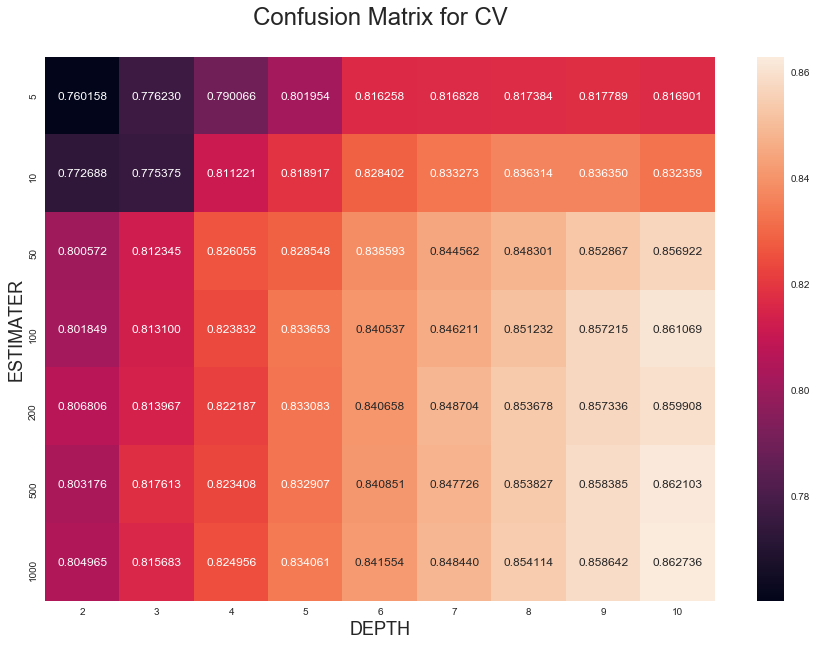

In [148]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc2, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")

plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for CV\n",size=24)
plt.show()

In [151]:
rf = RandomForestClassifier(n_estimators=100,max_depth=5)

# fitting the model
rf.fit(Xbow_tr_std, y_tr)

# predict the response
pred = rf.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the Random forest classifier for n_estimaters=%d and Depth = %d is %f%%' % (100,5, acc))


The accuracy of the Random forest classifier for n_estimaters=100 and Depth = 5 is 84.224518%


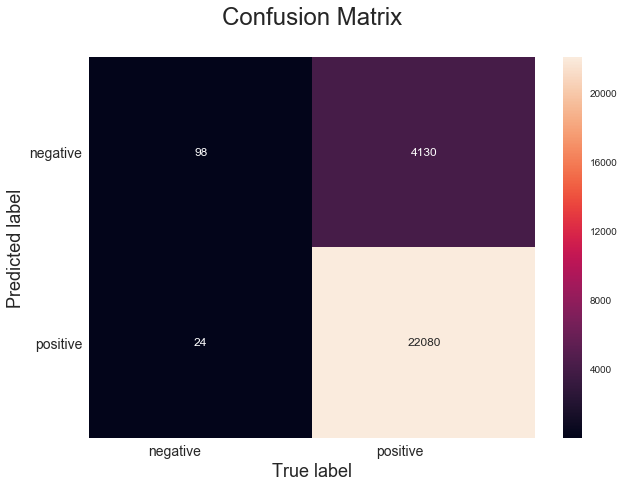

In [152]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [153]:

rf.fit(Xbow_tr_std, y_tr)
probs2 = rf.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = rf.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

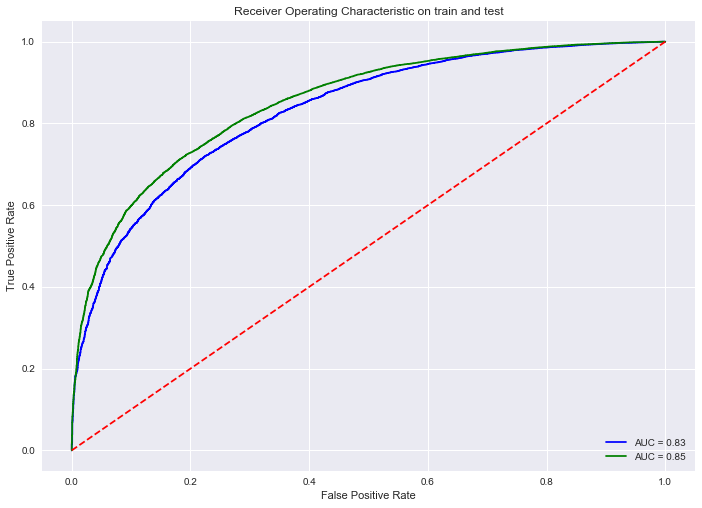

In [154]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [5.2] Applying GBDT using XGBOOST

In [55]:
from xgboost import XGBClassifier

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [57]:
#code for hyperparameter tuning
import numpy as np
hyper1 =  [5, 10, 50, 100, 200, 500, 1000]
hyper2 =  [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc1=np.empty((7,9))
auc2=np.empty((7,9))
l=0
for j in hyper1:
    m=0
    for k in hyper2:
        
        model = XGBClassifier(n_estimators=j,max_depth=k)
        model.fit(Xbow_tr_std, y_tr)
    
        probs = model.predict_proba(Xbow_tr_std)
        preds = probs[:,1]
        roc_auc1=metrics.roc_auc_score(y_tr, preds)
        auc1[l][m]=(roc_auc1)
    
  
        probs = model.predict_proba(Xbow_cv_std)
        preds = probs[:,1]
        roc_auc2=metrics.roc_auc_score(y_cv, preds)
        auc2[l][m]=(roc_auc2)
        m=m+1
        
    l=l+1
    
    



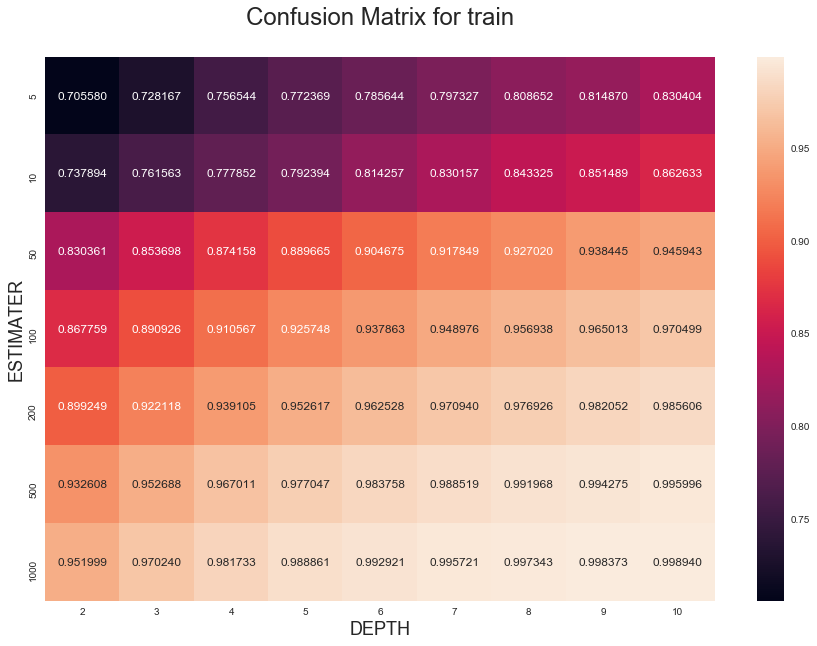

In [58]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc1, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for train\n",size=24)
plt.show()

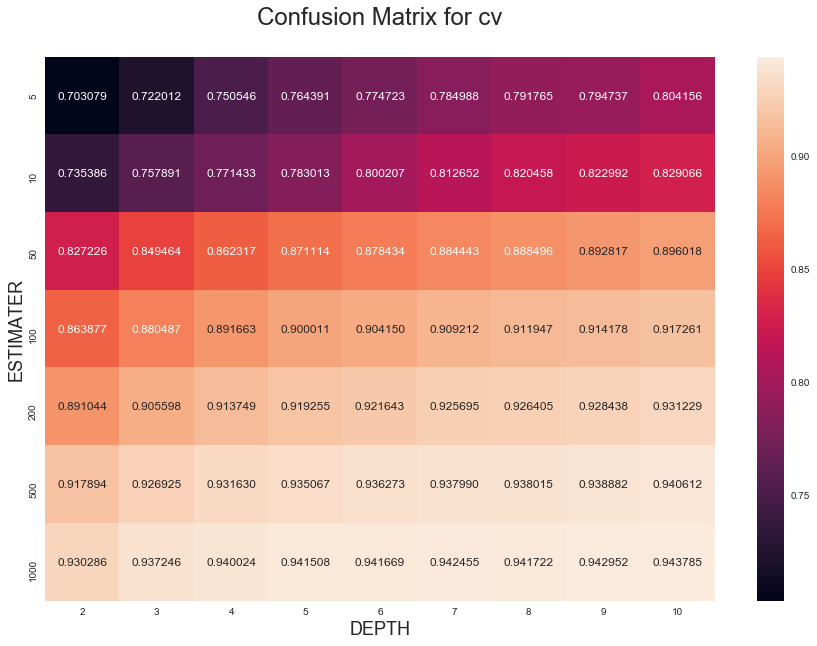

In [59]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc2, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for cv\n",size=24)
plt.show()

In [62]:
rf = XGBClassifier(n_estimators=100,max_depth=4)

# fitting the model
rf.fit(Xbow_tr_std, y_tr)

# predict the response
pred = rf.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the GBDT classifier for n_estimaters=%d and Depth = %d is %f%%' % (100,4,acc))


The accuracy of the GBDT classifier for n_estimaters=100 and Depth = 4 is 87.779128%


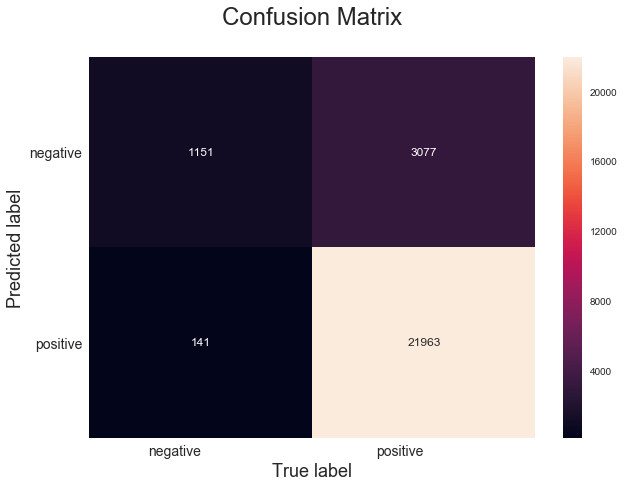

In [64]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [66]:

rf.fit(Xbow_tr_std, y_tr)
probs2 = rf.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = rf.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

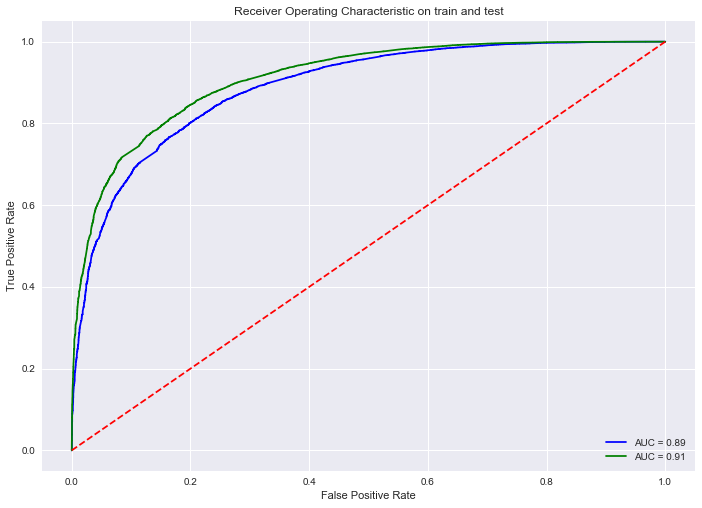

In [67]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

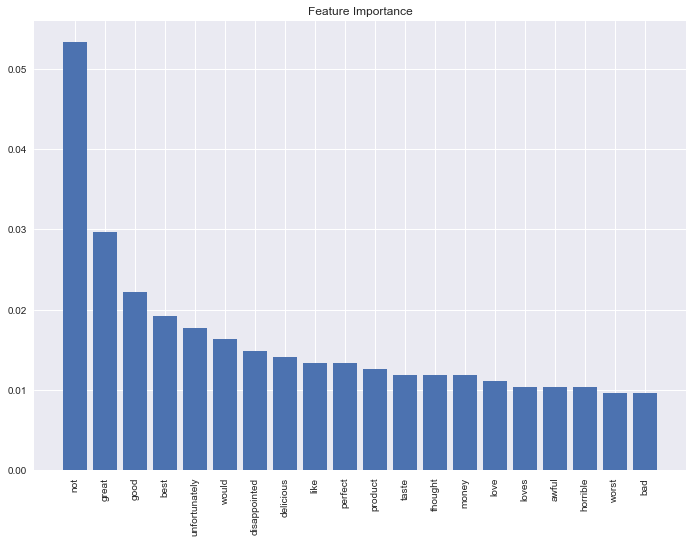

In [68]:
#refer code snippet for top 20 feature extraction
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
# Calculate feature importances from decision trees
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(20), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()from sklearn import tree



In [69]:
z=names[indices]
z

array(['not', 'great', 'good', 'best', 'unfortunately', 'would',
       'disappointed', 'delicious', 'like', 'perfect', 'product', 'taste',
       'thought', 'money', 'love', 'loves', 'awful', 'horrible', 'worst',
       'bad'], dtype='<U16')

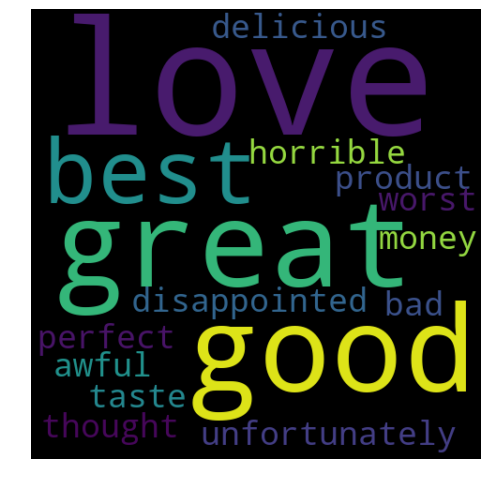

In [101]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
# Create a list of word
text=("not great good best unfortunately would disappointed delicious like perfect product taste thought money love loves awful horrible worst bad ") 
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [103]:
#code for hyperparameter tuning
import numpy as np
hyper1 =  [5, 10, 50, 100, 200, 500, 1000]
hyper2 =  [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc1=np.empty((7,9))
auc2=np.empty((7,9))
l=0
for j in hyper1:
    m=0
    for k in hyper2:
        
        model = XGBClassifier(n_estimators=j,max_depth=k)
        model.fit(Xbow_tr_std, y_tr)
    
        probs = model.predict_proba(Xbow_tr_std)
        preds = probs[:,1]
        roc_auc1=metrics.roc_auc_score(y_tr, preds)
        auc1[l][m]=(roc_auc1)
    
  
        probs = model.predict_proba(Xbow_cv_std)
        preds = probs[:,1]
        roc_auc2=metrics.roc_auc_score(y_cv, preds)
        auc2[l][m]=(roc_auc2)
        m=m+1
        
    l=l+1
    
    



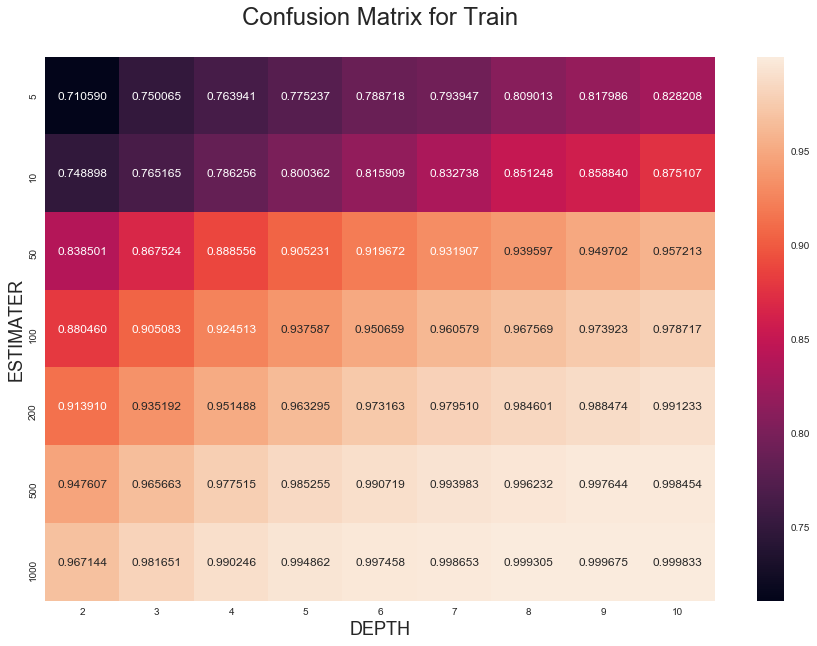

In [104]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc1, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")

plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for Train\n",size=24)
plt.show()

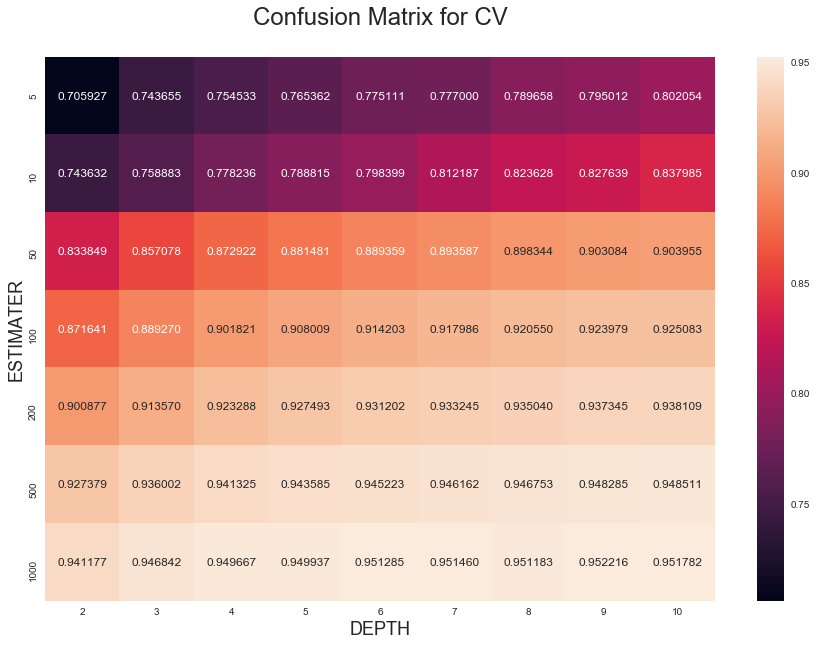

In [106]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc2, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for CV\n",size=24)
plt.show()

In [107]:
rf = XGBClassifier(n_estimators=50,max_depth=4)

# fitting the model
rf.fit(Xbow_tr_std, y_tr)

# predict the response
pred = rf.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the GBDT classifier for n_estimaters=%d and Depth = %d is %f%%' % (50,4, acc))


The accuracy of the GBDT classifier for n_estimaters=50 and Depth = 4 is 86.491721%


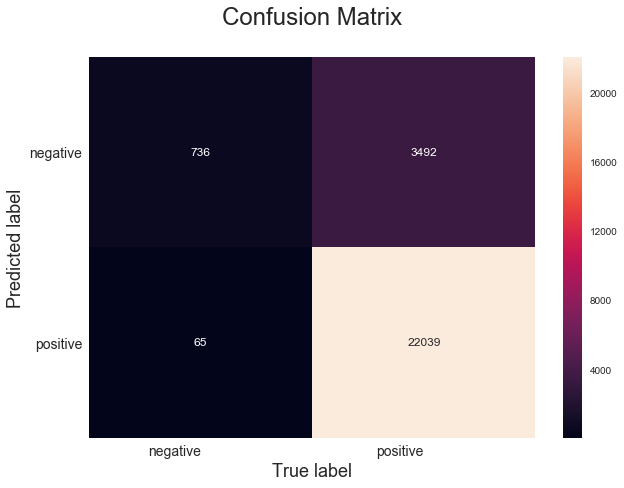

In [108]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [109]:

rf.fit(Xbow_tr_std, y_tr)
probs2 = rf.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = rf.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

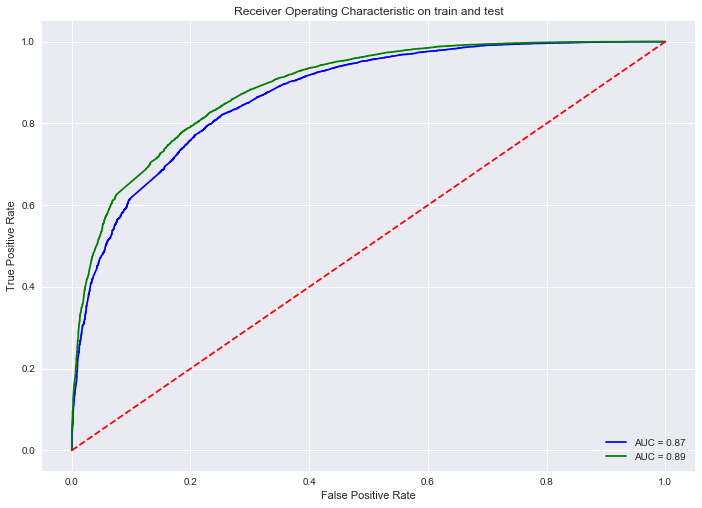

In [110]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

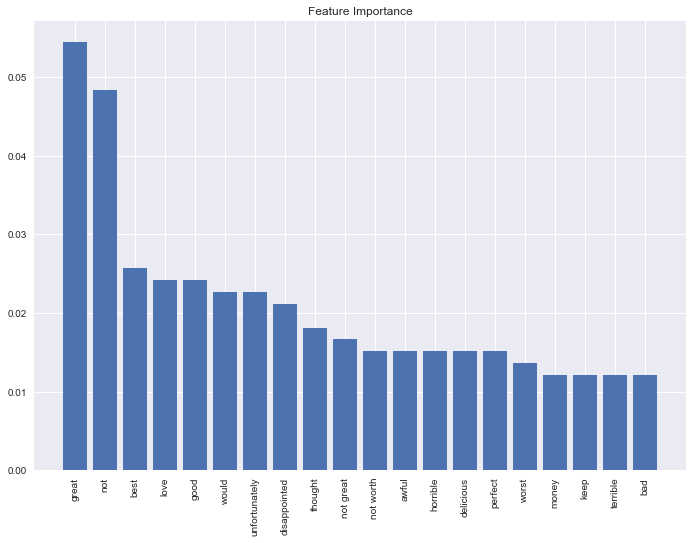

In [111]:
#refer code snippet for top 20 feature extraction
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
# Calculate feature importances from decision trees
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:20]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(20), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()from sklearn import tree



In [113]:
z=names[indices]
z

array(['great', 'not', 'best', 'love', 'good', 'would', 'unfortunately',
       'disappointed', 'thought', 'not great', 'not worth', 'awful',
       'horrible', 'delicious', 'perfect', 'worst', 'money', 'keep',
       'terrible', 'bad'], dtype='<U27')

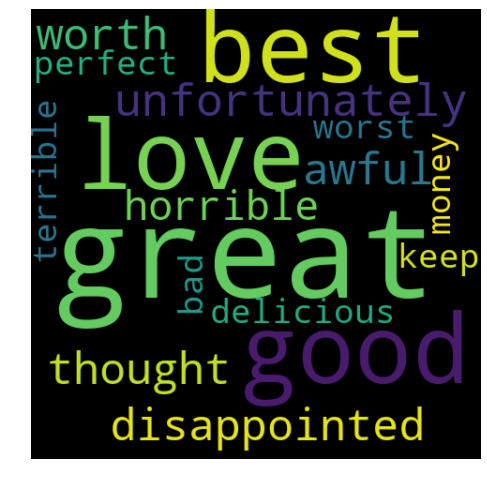

In [114]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
# Create a list of word
text=(" great not best love good would unfortunately disappointed thought not great not worth awful horrible delicious perfect worst money keep terrible bad ") 
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [130]:
#code for hyperparameter tuning
import numpy as np
hyper1 =  [5, 10, 50, 100, 200, 500, 1000]
hyper2 =  [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc1=np.empty((7,9))
auc2=np.empty((7,9))
l=0
for j in hyper1:
    m=0
    for k in hyper2:
        
        model = XGBClassifier(n_estimators=j,max_depth=k,nthread=-1)
        model.fit(Xbow_tr_std, y_tr)
    
        probs = model.predict_proba(Xbow_tr_std)
        preds = probs[:,1]
        roc_auc1=metrics.roc_auc_score(y_tr, preds)
        auc1[l][m]=(roc_auc1)
    
  
        probs = model.predict_proba(Xbow_cv_std)
        preds = probs[:,1]
        roc_auc2=metrics.roc_auc_score(y_cv, preds)
        auc2[l][m]=(roc_auc2)
        m=m+1
        
    l=l+1
    
    



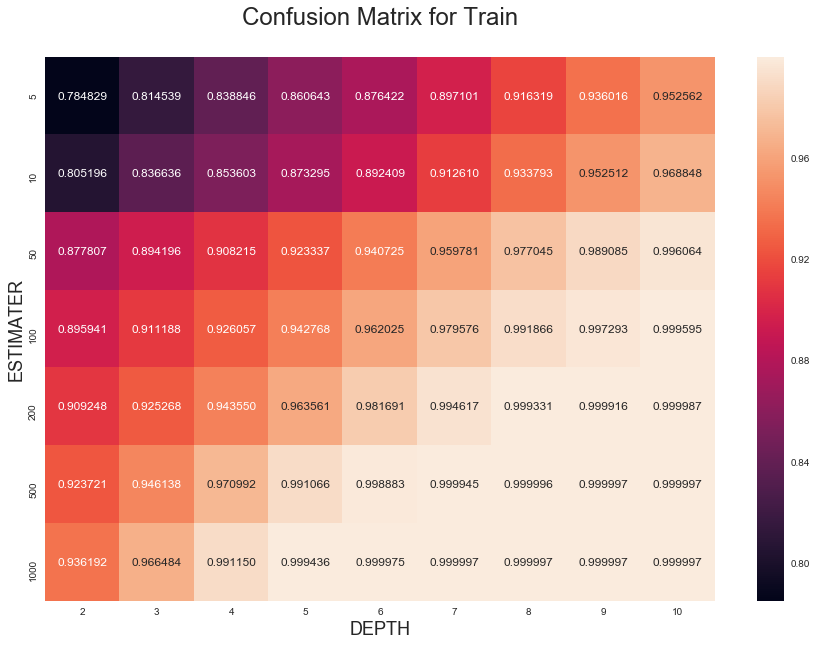

In [133]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc1, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for Train\n",size=24)
plt.show()

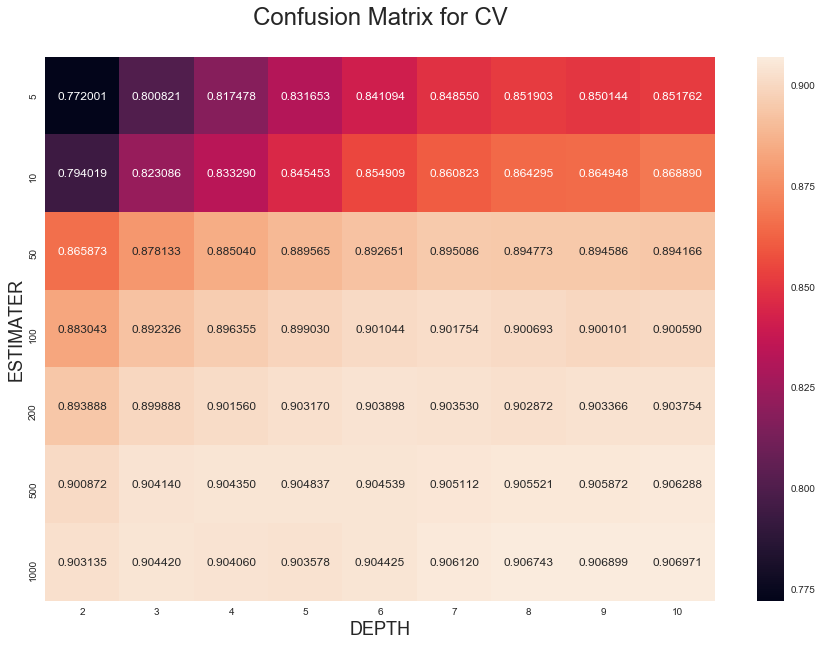

In [134]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc2, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")

plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for CV\n",size=24)
plt.show()

In [135]:
rf = XGBClassifier(n_estimators=10,max_depth=4)

# fitting the model
rf.fit(Xbow_tr_std, y_tr)

# predict the response
pred = rf.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the GBDT classifier for n_estimaters=%d and Depth = %d is %f%%' % (10,4, acc))


The accuracy of the GBDT classifier for n_estimaters=10 and Depth = 4 is 86.020811%


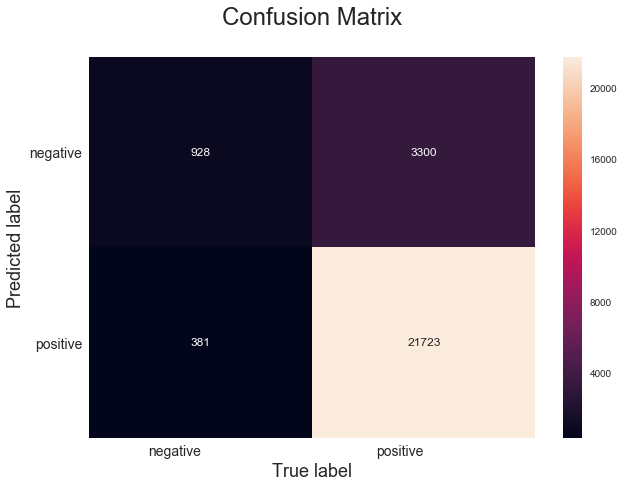

In [136]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [137]:

rf.fit(Xbow_tr_std, y_tr)
probs2 = rf.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = rf.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

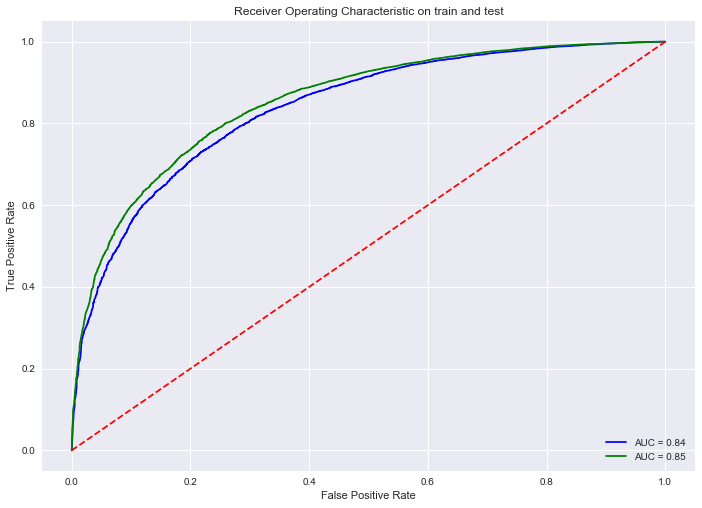

In [138]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [155]:
#code for hyperparameter tuning
import numpy as np
hyper1 =  [5, 10, 50, 100, 200, 500, 1000]
hyper2 =  [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc1=np.empty((7,9))
auc2=np.empty((7,9))
l=0
for j in hyper1:
    m=0
    for k in hyper2:
        
        model = XGBClassifier(n_estimators=j,max_depth=k)
        model.fit(Xbow_tr_std, y_tr)
    
        probs = model.predict_proba(Xbow_tr_std)
        preds = probs[:,1]
        roc_auc1=metrics.roc_auc_score(y_tr, preds)
        auc1[l][m]=(roc_auc1)
    
  
        probs = model.predict_proba(Xbow_cv_std)
        preds = probs[:,1]
        roc_auc2=metrics.roc_auc_score(y_cv, preds)
        auc2[l][m]=(roc_auc2)
        m=m+1
        
    l=l+1
    
    



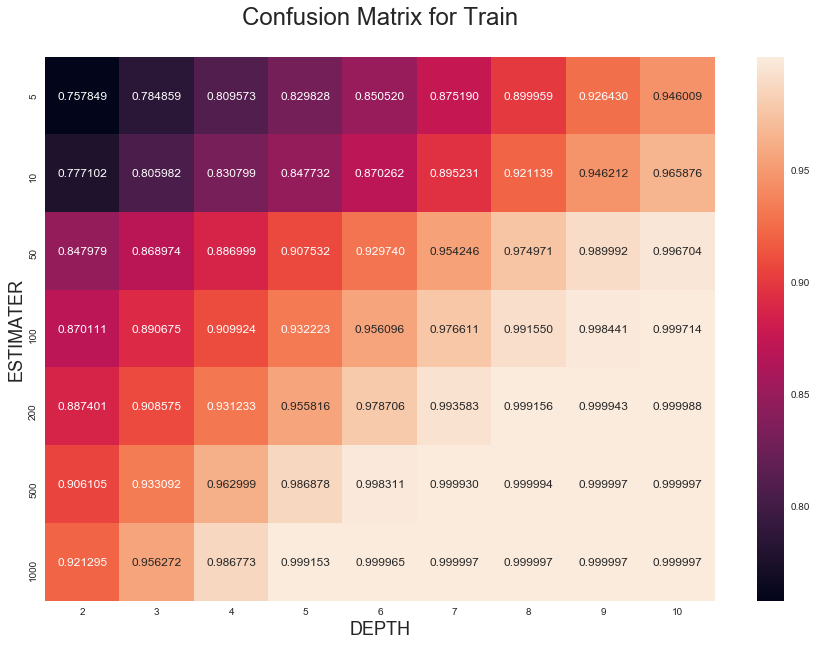

In [156]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc1, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for Train\n",size=24)
plt.show()

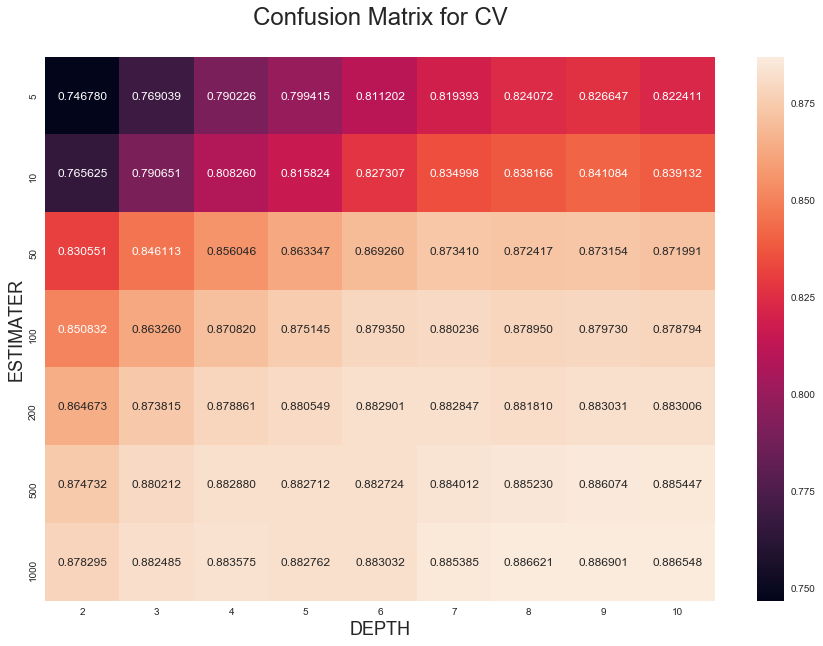

In [157]:
import numpy as np;
import seaborn as sns; sns.set()

# Code for drawing seaborn heatmaps

df_heatmap =pd.DataFrame(auc2, hyper1, hyper2 )
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(df_heatmap, annot=True, fmt="f")


plt.ylabel('ESTIMATER',size=18)
plt.xlabel('DEPTH',size=18)
plt.title("Confusion Matrix for CV\n",size=24)
plt.show()

In [159]:
rf = XGBClassifier(n_estimators=100,max_depth=4)

# fitting the model
rf.fit(Xbow_tr_std, y_tr)

# predict the response
pred = rf.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the GBDT classifier for n_estimaters=%d and Depth = %d is %f%%' % (100,4, acc))


The accuracy of the GBDT classifier for n_estimaters=100 and Depth = 4 is 87.349992%


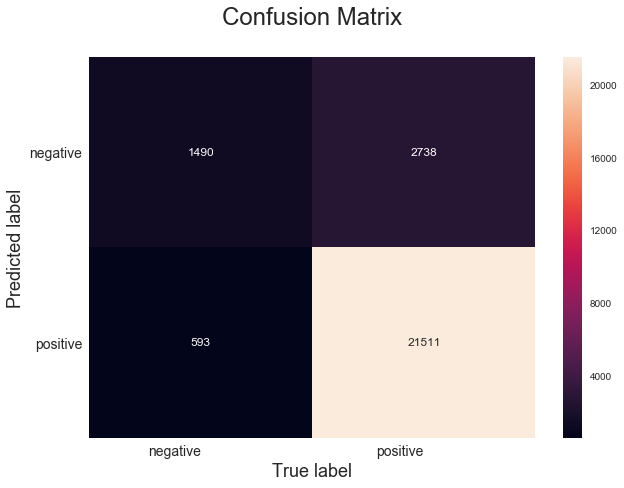

In [165]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [161]:

rf.fit(Xbow_tr_std, y_tr)
probs2 = rf.predict_proba(Xbow_tr_std)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = rf.predict_proba(Xbow_test_std)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)

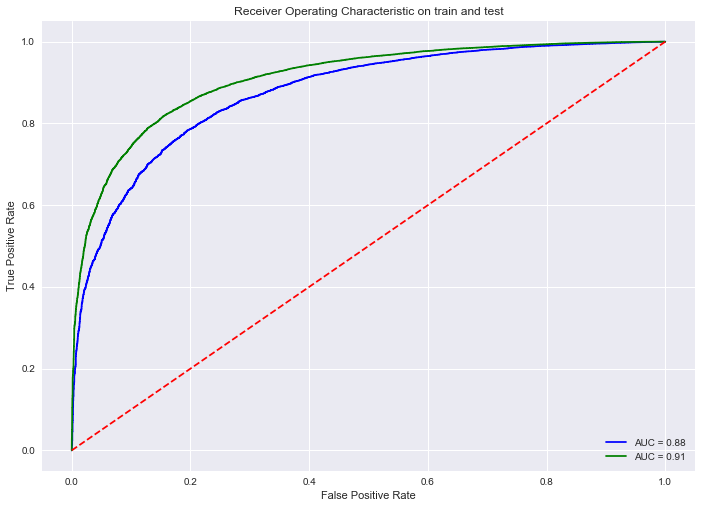

In [162]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [6] Conclusions

In [164]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vactorizer", "Model","n_estimators","max_depth", "AUC%"]

x.add_row(["BOW", "Random Forest",50,3,83.94])

x.add_row(["TFIDF", "Random Forest",100,4,83.94])

x.add_row(["AVGW2V", "Random Forest",10,4,84.08])

x.add_row(["TFIDFW2V","Random Forest",100,5,84.22])

x.add_row(["BOW", "GBDT",100,4,87.77])

x.add_row(["TFIDF", "GBDT",50,4,86.49])

x.add_row(["AVGW2V", "GBDT",10,4, 86.02])

x.add_row(["TFIDFW2V","GBDT",100,4,87.34])


print(x)

+------------+---------------+--------------+-----------+-------+
| Vactorizer |     Model     | n_estimators | max_depth |  AUC% |
+------------+---------------+--------------+-----------+-------+
|    BOW     | Random Forest |      50      |     3     | 83.94 |
|   TFIDF    | Random Forest |     100      |     4     | 83.94 |
|   AVGW2V   | Random Forest |      10      |     4     | 84.08 |
|  TFIDFW2V  | Random Forest |     100      |     5     | 84.22 |
|    BOW     |      GBDT     |     100      |     4     | 87.77 |
|   TFIDF    |      GBDT     |      50      |     4     | 86.49 |
|   AVGW2V   |      GBDT     |      10      |     4     | 86.02 |
|  TFIDFW2V  |      GBDT     |     100      |     4     | 87.34 |
+------------+---------------+--------------+-----------+-------+


# ------->> Step followered:-

STEP 1 :- Data cleaning (removing duplication).

STEP 2 :- Text Preprocessing.

STEP 3:- Featurization on text reviews i.e BOW,TFIDF,avgW2V,TFIDF-W2V.

STEP 4:- Standardization on vectors i.e BOW,TFIDF,avgW2V,TFIDF-W2V.

STEP 5:- Plot the performance of model both on train data and cross validation data for each hyper parameter with rows as n_estimators, columns as max_depth, and values inside the cell representing AUC Score to analise overfitting and underfitting using Seaborn Heatmap.

STEP 6:- Once , we analise optimal value of n_estimators and max_depth then we train the MODEL again with this analised optimal n_estimators and max_depth and make predictions on test_data. 

STEP 7:- Compute test accuracy using predicted values of test_data.

STEP 8:- Plot Seaborn Heatmap for representation of Confusion Matrix on Random Forest and GBDT model.

STEP 9:- Plot ROC curve for train and test on Random Forest and GBDT model.


----->>>> Repeat from STEP 4 to STEP 9 for each of these four vectorizers : Bag Of Words(BoW), TFIDF , Avg Word2Vec and TFIDF Word2Vec saparately on Random Forest and GBDT model.

------>>>> We extract the top 20 important features from SET1 and SET2 i.e BOW AND TFIDF vectorizer in Random Forest and GBDT model and represent them in a word cloud.

--------------->>>>> AT THE END WE MAKE A TABLE TO COMPAIR OUR RESULTS OF Random Forest and GBDT model with different vectorizers and hyperparameter(n_estimators and max_depth).